In [1]:
import os
from langchain_community.embeddings import OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_community.document_loaders import TextLoader
from langchain_community.embeddings.sentence_transformer import (
    SentenceTransformerEmbeddings,
)
from langchain_text_splitters import CharacterTextSplitter,RecursiveCharacterTextSplitter
import chromadb
from langchain_community.document_loaders import DirectoryLoader
import configs
import pandas as pd
from pypdf import PdfReader
import plotly.express as px
from sklearn.manifold import TSNE
from deep_translator import GoogleTranslator
import re 
import plotly.express as px
from sklearn.manifold import TSNE
from plotly.offline import init_notebook_mode
from pypdf import PdfReader
from collections import defaultdict
from langdetect import detect
init_notebook_mode()
from openai import OpenAI
import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import plotly.express as px
import matplotlib.pyplot as plt
import openai
from PIL import Image
import numpy as np

# Scope of this Document

## Highlevel
 this Document is used to Compare my CV with multiple Job Offers from Linkedin (which i parsed) to ensure i select the right Occypations which are listed on the Internet. The entire Projects consists of 3 Main Stages.

- Extracting Data from LinkedIn via >> parse_data_linkedin_1.py
- Finding Similarities between the parsed Job descriptions and my curriculum vitae as exhibted in here
- Generating the Cover Letters for the corresponding Applications >> write_mails_4.py


<p>If you ended up in here that probably means that we have a lot in comming and probably should have a chat &#128521;</p>

- 1.1 Preprocess the Data
- 1.2 Load all LinkedIn Applications an my CV
- 1.3 Split the Documents
- 1.4 Create Embeddings
- 1.5 Calculate Similarity Measures
- 1.6 Reduce the Dimensionality Plot results
- 1.7 compare best vs worst result

## 1.1 Preprocess the Data

In [2]:
# preprocess data we need to translate all german applciations 

if not os.path.exists('./processed_data/texts_eng'):
    os.makedirs('./processed_data/texts_eng')
for file in tqdm.tqdm(os.listdir('./processed_data/texts')):
    pth=os.path.join('./processed_data/texts',file)
    f = open(pth, "r")
    content=f.read()
    filtered_content = re.sub(r'[^\w\s\t\n.\;,:-]', '', content)
    translated = GoogleTranslator(source='auto', target='en').translate(filtered_content[:4800])

    f = open(os.path.join('./processed_data/texts_eng',file), "w")
    f.write(translated)
    f.close()
    



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2399/2399 [13:19<00:00,  3.00it/s]


## 1.2 Load all LinkedIn Applications an my CV

In [2]:
# Load PDF and extract text from the first page
pdf_file = PdfReader('cv/ResumeeZeynepTozge.pdf')
page = pdf_file.pages[0]
page_text = page.extract_text()

# Set API key
os.environ["OPENAI_API_KEY"] = configs.OPENAI_API_KEY
openai.api_key = configs.OPENAI_API_KEY

# Load documents from directory
loader = DirectoryLoader('./processed_data/texts_eng', glob="*.txt")
documents = loader.load()

## 1.3 Split the Document

In [3]:
# Split documents into chunks using RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=0) # make sure each document is iin a split 
chunk_sources = []
chunks = []
for doc in documents:
    for chunk in text_splitter.split_text(doc.page_content):
        chunks.append(chunk)
        chunk_sources.append(doc.metadata['source'])


## 1.4 Create Embeddings

In [4]:
# Initialize embeddings and Chroma client
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
new_client = chromadb.EphemeralClient()
openai_lc_client = Chroma.from_texts(
    chunks, embeddings, client=new_client, collection_name="openai_collection", persist_directory='./dbs' # create local embeddings
)

# Debug: Retrieve embeddings and check consistency
vecs = openai_lc_client._collection.get(include=['embeddings']) # compare dimensions
print(f"Number of retrieved embeddings: {len(vecs['embeddings'])}")
print(f"Number of chunks: {len(chunks)}")


/home/tempa/.local/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning:

The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.



Number of retrieved embeddings: 5294
Number of chunks: 5294


In [65]:
cmb=pd.DataFrame(data={'chunk':chunks,'chunk_src':chunk_sources})

In [73]:

# Perform similarity search
store = defaultdict(list)
results_with_scores = openai_lc_client.similarity_search_with_score(page_text, k=len(chunks))

# Store results in a DataFrame, including embeddings
for i, (doc, score) in enumerate(results_with_scores):
    store['files'].append(cmb.iloc[np.argwhere(cmb.chunk.values.reshape(-1)==doc.page_content)[0],:].chunk_src.squeeze())
    store['scores'].append(score)
    store['content'].append(doc.page_content)
    store['embeddings'].append(vecs['embeddings'][np.argwhere(np.array(vecs['documents'])==doc.page_content)[[0]][0][0]])

df = pd.DataFrame(store)

# Debug: Check DataFrame content
print(df.head())

# Additional debugging information
print(f"Length of results_with_scores: {len(results_with_scores)}")
print(f"Length of store['files']: {len(store['files'])}")


                                               files    scores  \
0  processed_data/texts_eng/Jop_Application_2435.txt  0.828633   
1  processed_data/texts_eng/Jop_Application_3259.txt  0.829912   
2  processed_data/texts_eng/Jop_Application_3259.txt  0.829983   
3  processed_data/texts_eng/Jop_Application_1436.txt  0.834748   
4  processed_data/texts_eng/Jop_Application_1684.txt  0.836801   

                                             content  \
0  Working Student Energy Modeling Analyst fmd\n\...   
1  Project engineer in the field of power electro...   
2  Project engineer in the field of power electro...   
3  Energy technology engineer in Erding wmd\n\nMo...   
4  Project engineer for electrical engineering, p...   

                                          embeddings  
0  [-0.021766507998108864, 0.020251013338565826, ...  
1  [-0.01737082749605179, 0.01611635647714138, -0...  
2  [-0.01737082749605179, 0.01611635647714138, -0...  
3  [-0.003952821251004934, 0.01431139931082725

## 1.6 Reduce the Dimensionality|KMeans Cluserting Plot results

In [74]:
# Convert embeddings to a NumPy array
embedding_array = np.array(df['embeddings'].tolist())

# Function to perform KMeans clustering and calculate silhouette scores
def find_best_k(embedding_array, max_k=10):
    silhouette_scores = []
    models = []
    
    for k in range(2, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(embedding_array)
        silhouette_avg = silhouette_score(embedding_array, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        models.append((k, kmeans))
        
    best_k = np.argmax(silhouette_scores) + 2  # +2 because range starts from 2
    best_model = models[np.argmax(silhouette_scores)][1]
    
    return best_k, best_model, silhouette_scores

# Find the best k and corresponding KMeans model
best_k, best_model, silhouette_scores = find_best_k(embedding_array, max_k=10)

# Predict clusters using the best model
df['Cluster'] = best_model.predict(embedding_array)

In [75]:
# Create a t-SNE model
tsne_model = TSNE(
    n_components=2,
    perplexity=50,
    random_state=42,
    init='random',
    learning_rate=200
)
tsne_embeddings = tsne_model.fit_transform(embedding_array)

# Create a DataFrame for visualization
visualisation_data = pd.DataFrame(
    {'x': tsne_embeddings[:, 0],
     'y': tsne_embeddings[:, 1],
     'Similarity': df['scores'],
    'Files':df['files']}
    
)

# Create the scatter plot using Plotly Express
plot = px.scatter(
    visualisation_data,
    x='x',
    y='y',
    color='Similarity',
    hover_data='Files',
    color_continuous_scale='rainbow',
    opacity=0.3,
    title="Similarity visualization using t-SNE"
)

plot.update_layout(
    width=950,
    height=950
)



plotly_image_path = 'plotly_chart_1.png'
plot.write_image(plotly_image_path)

# Open the saved image using PIL
image = Image.open(plotly_image_path)



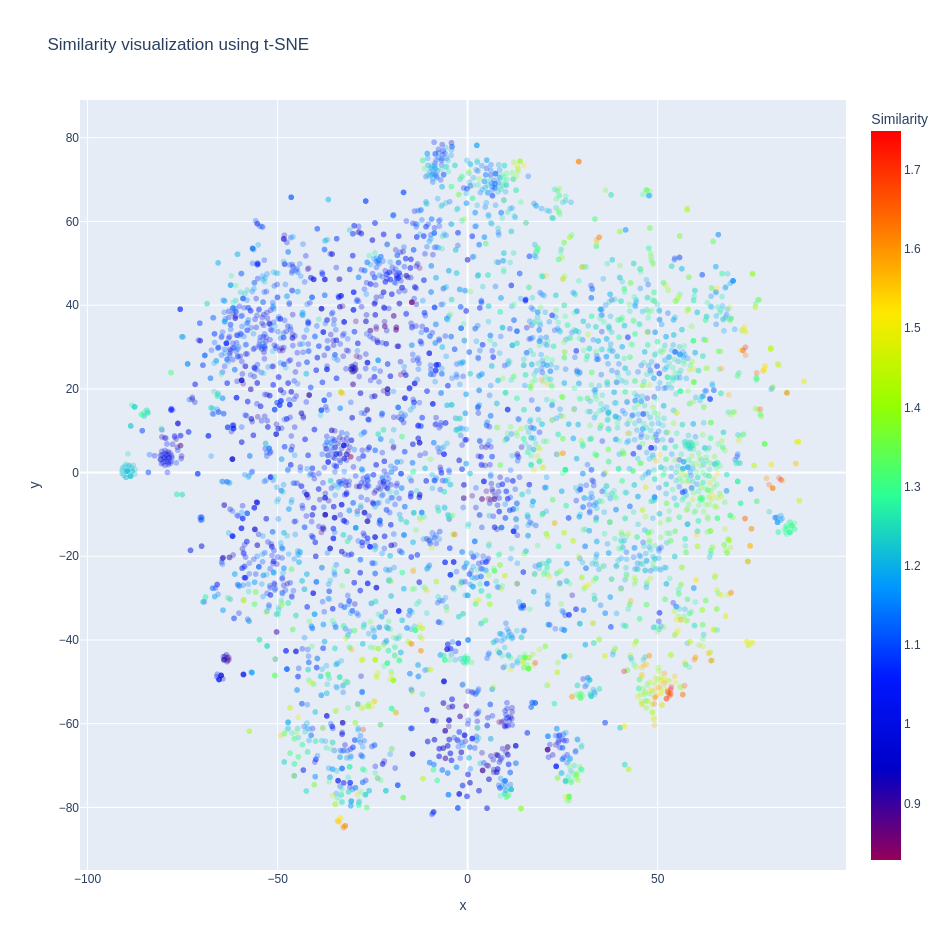

In [76]:
image

In [77]:

# Create a DataFrame for visualization
visualisation_data = pd.DataFrame(
    {'x': tsne_embeddings[:, 0],
     'y': tsne_embeddings[:, 1],
     'Similarity': df['scores'],
    'Files':df['files'],
    'cluster':df['Cluster']}
    
)

# Create the scatter plot using Plotly Express
plot = px.scatter(
    visualisation_data,
    x='x',
    y='y',
    color='cluster',
    hover_data='Files',
    color_continuous_scale='plasma',
    opacity=0.3,
    title="Cluster visualization using t-SNE"
)

plot.update_layout(
    width=950,
    height=950
)

# Show the plot
plotly_image_path = 'plotly_chart_2.png'
plot.write_image(plotly_image_path)

# Open the saved image using PIL
image = Image.open(plotly_image_path)



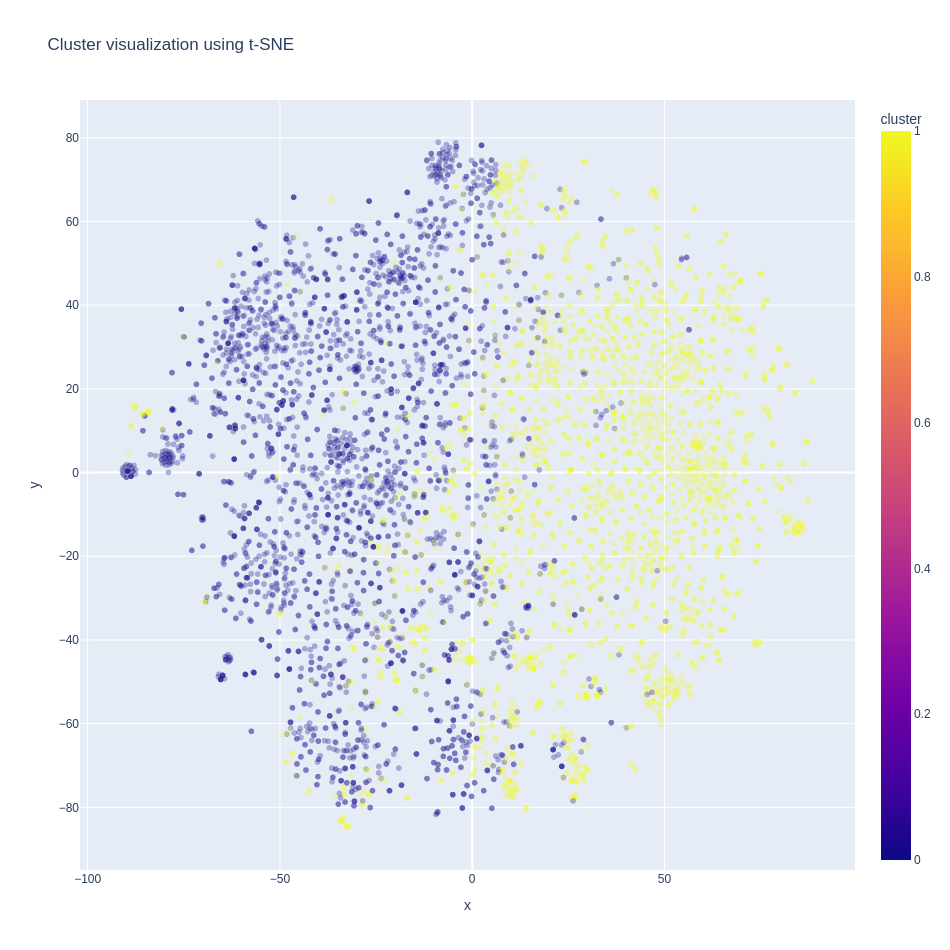

In [78]:
image

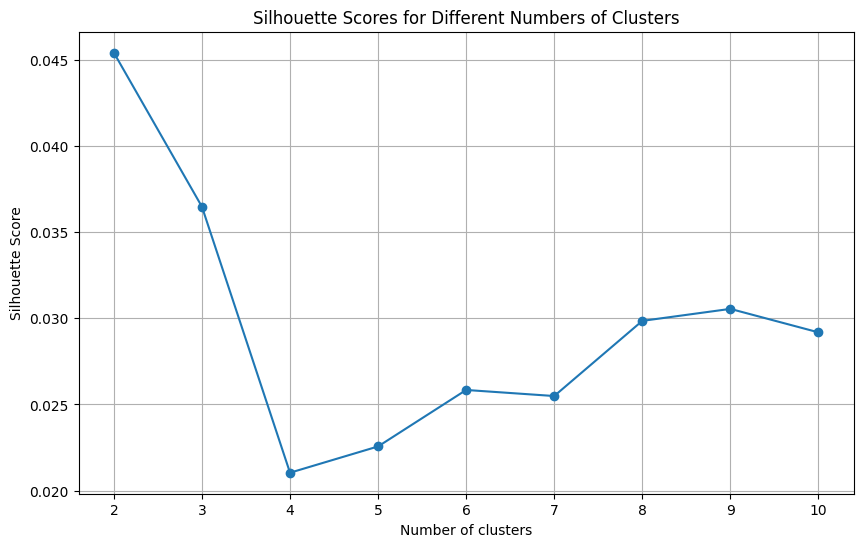

In [79]:
# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()

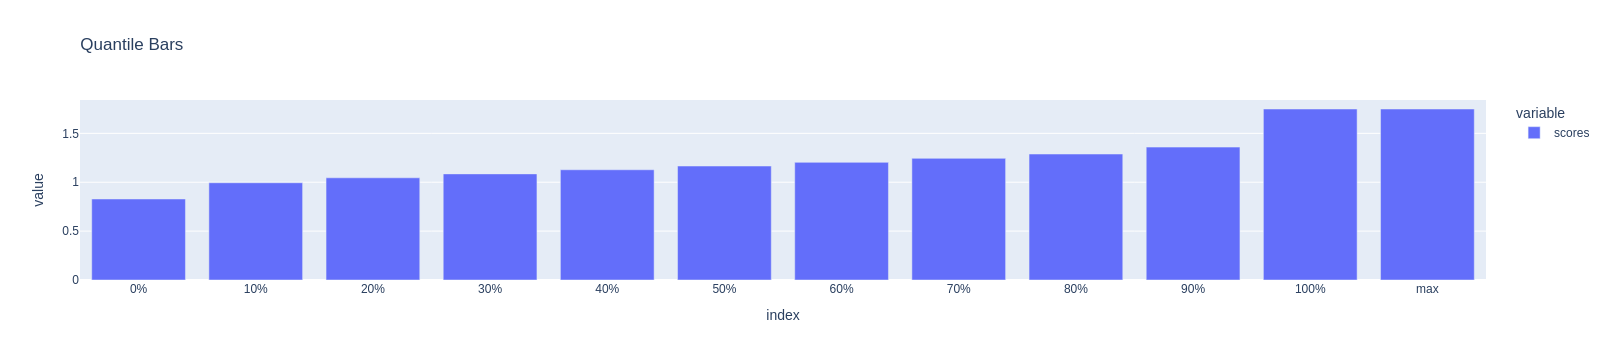

In [80]:

px.bar(df.scores.describe(percentiles=np.linspace(0,1,11)).iloc[4:],title='Quantile Bars')

## 1.7 compare best vs worst result

In [81]:
help(openai_lc_client.similarity_search_with_score) # the lower the score the more similarity

Help on method similarity_search_with_score in module langchain_chroma.vectorstores:

similarity_search_with_score(query: 'str', k: 'int' = 4, filter: 'Optional[Dict[str, str]]' = None, where_document: 'Optional[Dict[str, str]]' = None, **kwargs: 'Any') -> 'List[Tuple[Document, float]]' method of langchain_chroma.vectorstores.Chroma instance
    Run similarity search with Chroma with distance.
    
    Args:
        query: Query text to search for.
        k: Number of results to return. Defaults to 4.
        filter: Filter by metadata. Defaults to None.
        where_document: dict used to filter by the documents.
                E.g. {$contains: {"text": "hello"}}.
        **kwargs: Additional keyword arguments to pass to Chroma collection query.
    
    Returns:
        List of documents most similar to the query text and
        distance in float for each. Lower score represents more similarity.



### Best match

In [82]:
df.nsmallest(5,columns='scores').iloc[0].content # score 0.837451 feel free to compare it to my cv and find also the similarities

'Working Student Energy Modeling Analyst fmd\n\nE.ON Munich\n\nE.ON Energy Projects GmbH designs, finances, builds, operates and optimises decentralised, large-scale power generation plants for industrial customers. Since 2000, we realised projects of more than 1 gigawatt across Europe. With our bespoke integrated solutions, we drive decarbonisation and digitalisation in the energy-intensive industries. We shape the future of energy. At E.ON diversity matters. We welcome all people and are convinced that differences make us stronger. Become part of our inclusive and diverse company culture To create equal opportunities for everyone we offer our positions in full- or part-time. Seize the chance to become part of our E.ON Energy Projects GmbH team in München as soon as possible and apply online now as Working Student Energy Modeling Analyst fmd. Create perspectives not only for the future of E.ON, but also for your own. We cant wait to meet you, because none of us is as strong as all of 

### Worst match 

In [83]:
df.nlargest(5,columns='scores').iloc[0].content # score 1.749724

'The company received early-stage funding from Andreessen Horowitz, Initialized Capital, and Polychain Capital, with angel investments from Balaji Srinivasan and Naval Ravikant. Join us and be a pioneer in a new technology that will have implications across a range of verticals such as finance, gaming, investing, collectibles, among many others. Ava Labs is committed to diversity in the workplace and were proud to be an Equal Opportunity Employer. We do not hire on basis of race, color, religion, creed, gender, national origin, citizenship, age, disability, veteran status, marital status, pregnancy, parental status, sex, gender expression or identity, sexual orientation, or any other basis protected by local, state or federal law. All employment is decided on the basis of qualifications, merit, and business need.'

In [84]:
df.to_csv('embedding_scores.csv',sep="|")